# Importing Libraries

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# to display all coulmns of a dataframe
pd.set_option('display.max_column', None)

# to display all rows of a dataframe
pd.set_option('display.max_rows', None)

# to display all items of a long sequence
pd.set_option('display.max_seq_items', None)

# to display complete contents inside a cell in dataframe
pd.set_option('display.max_colwidth', None)

pd.set_option('expand_frame_repr', True)

# Reading and Understanding the Data

In [3]:
bike_df = pd.read_csv("day.csv")

In [4]:
# Check the head of the dataset
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# data contains 730 rows and 16 columns

In [5]:
bike_df.shape

(730, 16)

# These columns are not required from model development point of view. Let's drop them.

In [6]:
drop_these_columns = ["instant",
                      "dteday"]
bike_df.drop(drop_these_columns, inplace=True, axis=1)
bike_df.shape

(730, 14)

# Visualising the Data

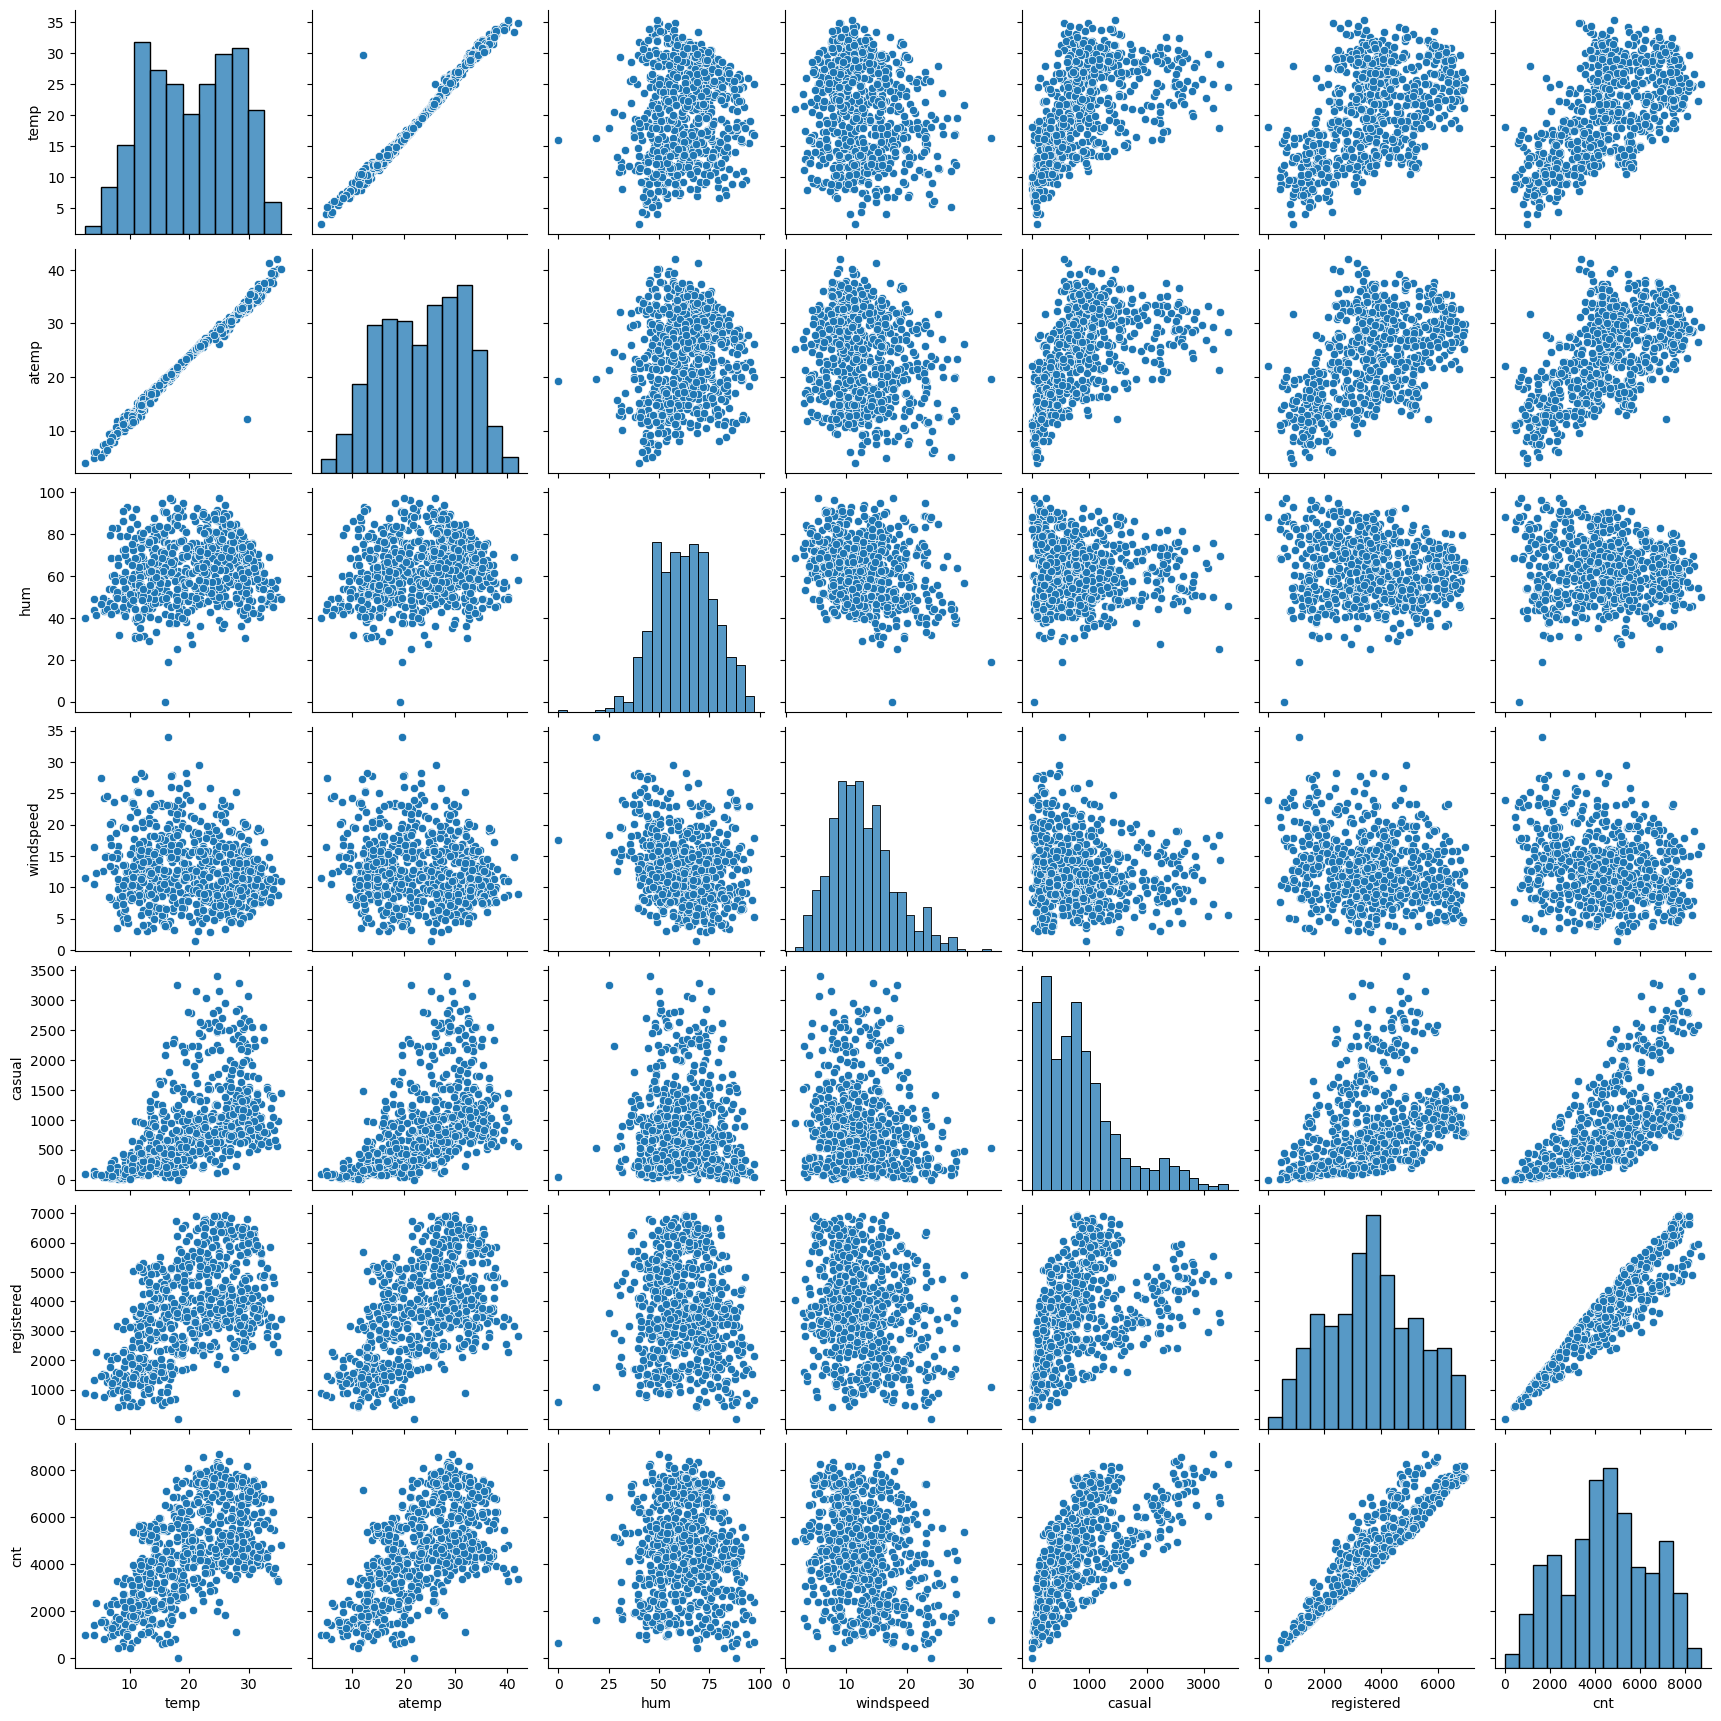

In [7]:
sns.pairplot(bike_df[["temp","atemp","hum","windspeed","casual","registered","cnt"]])
plt.show()


# Few observations from above pairplot:
1. temp and atemp are highly correlated.
2. temp is also correlated with casual, registered and cnt.
3. atemp is also correlated with casual, registered and cnt.
4. casual is correlated with registered and cnt. And thats obvious because casual + registered = cnt
We need to take care of these correlations among possible predictor variables to avoid multicollinearity once we start building our Multiple Linear Regression Model.
Also we will not use casual and registered in our preprocessed data for model training. This might leak out the crucial information and model might get overfit.

# Let's check the correlation coefficients to see which variables are highly correlated

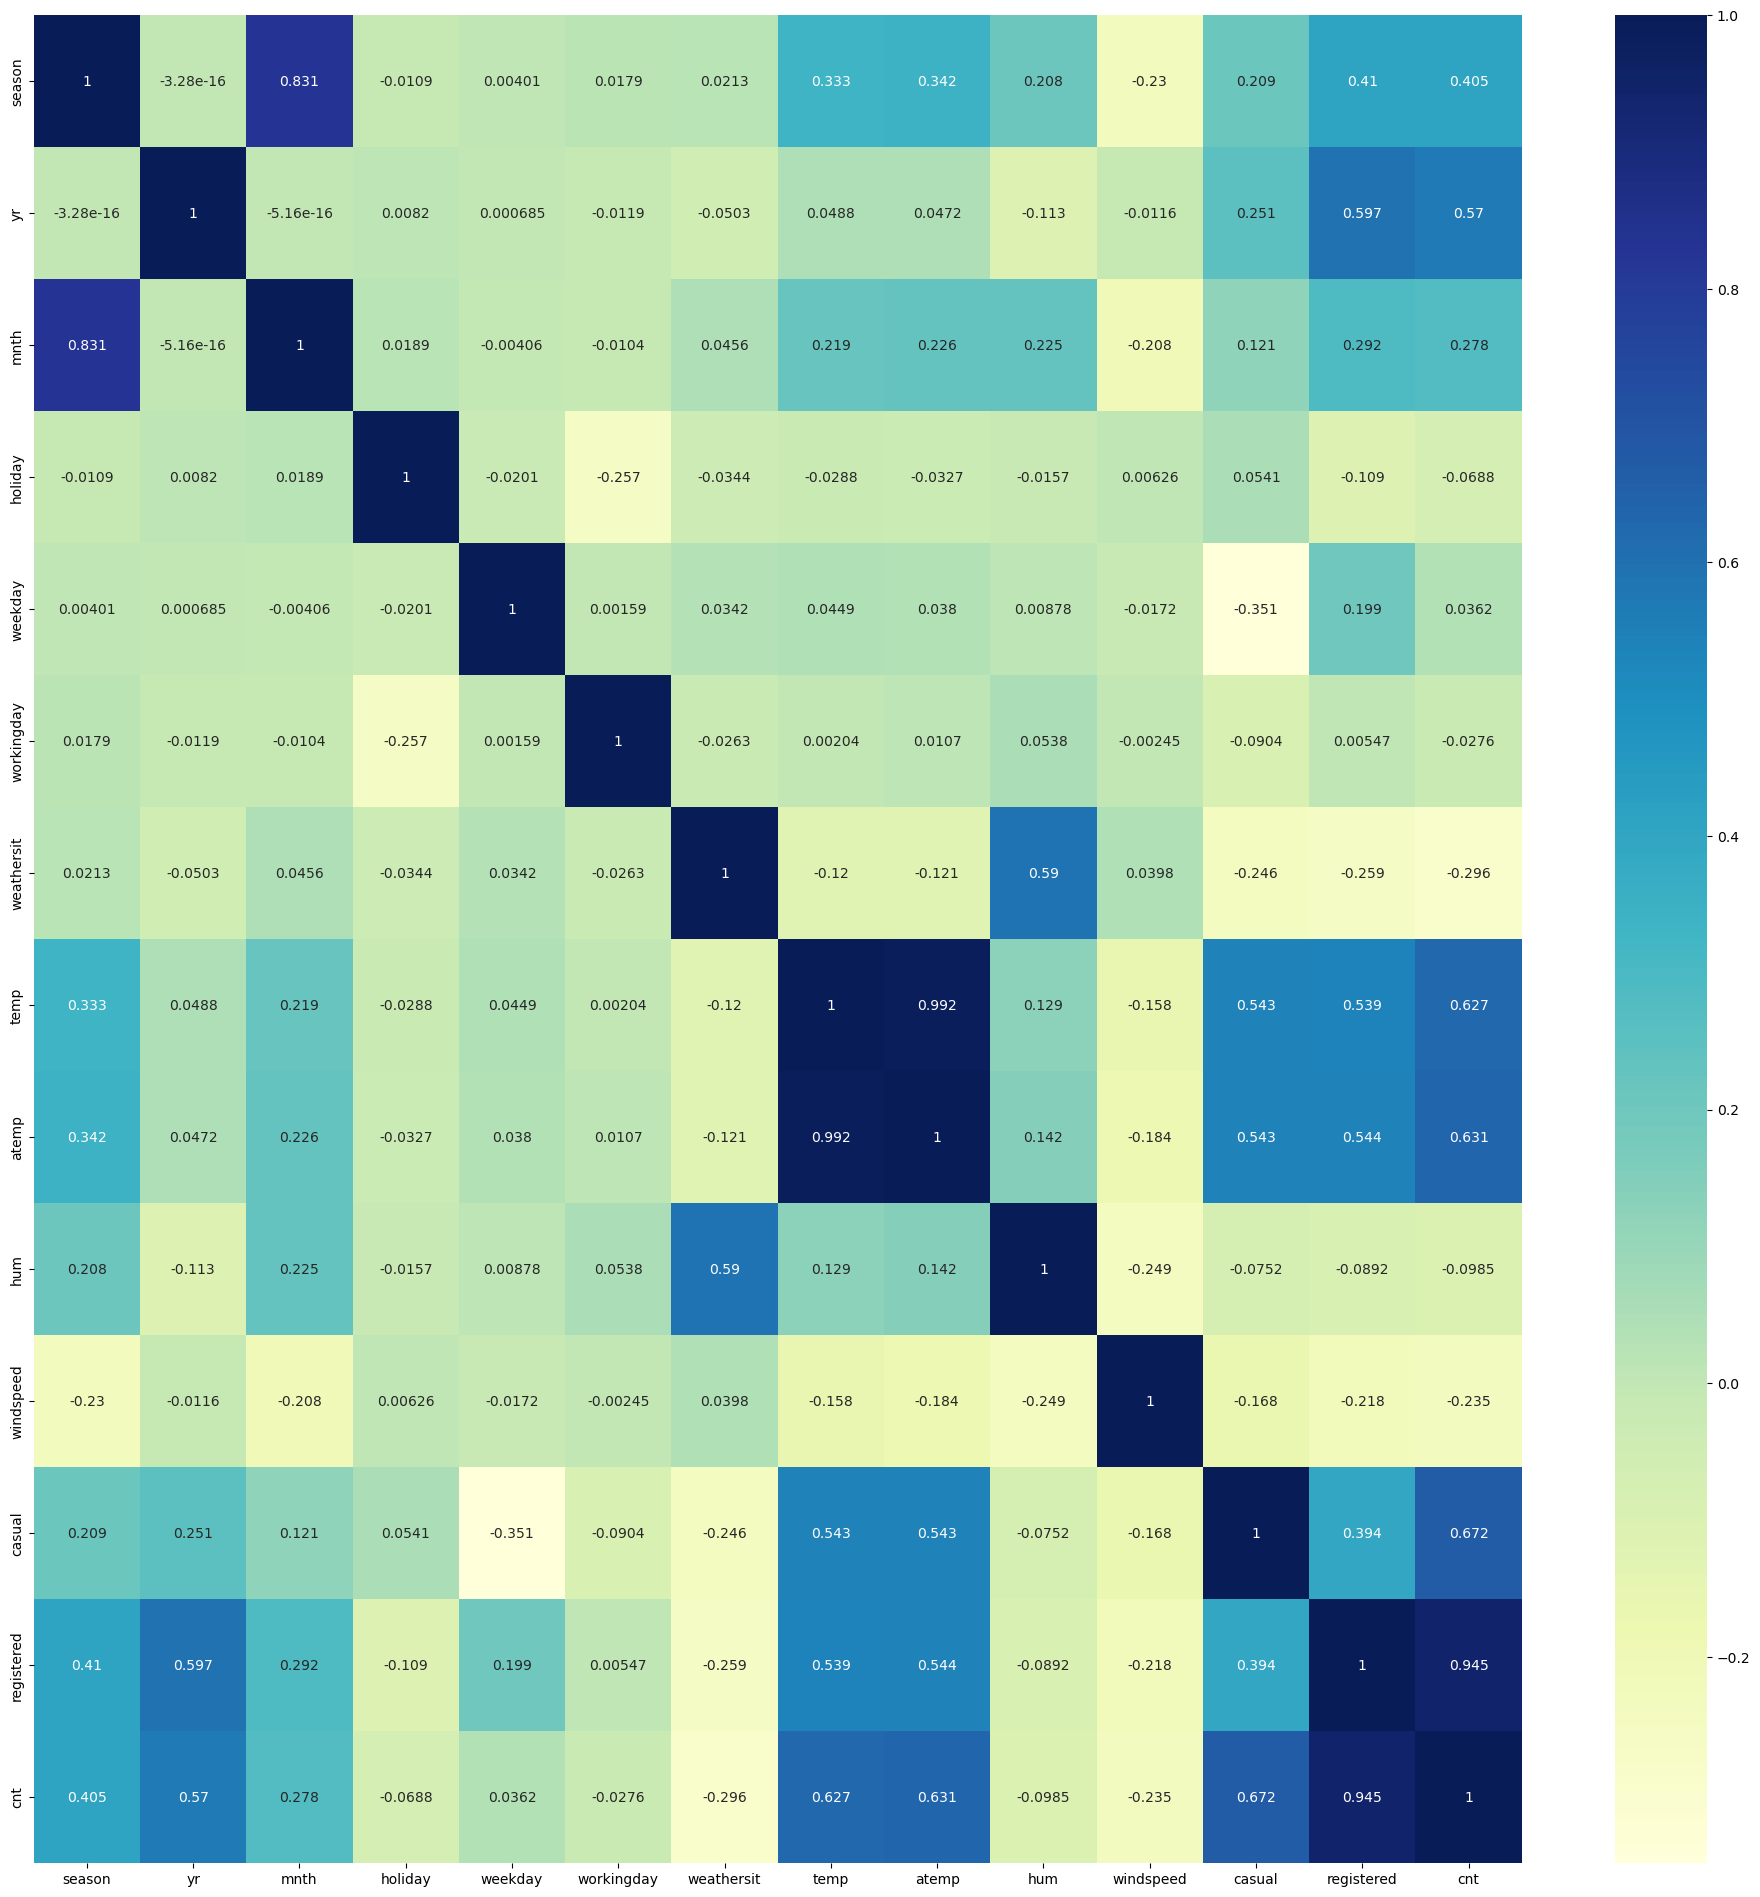

In [8]:
plt.figure(figsize = (24, 24))
sns.heatmap(bike_df.corr(), annot = True, fmt='0.3g', cmap="YlGnBu")
plt.show()

# Few observations from above heat map:
1) Apart from casual and registered (we'll drop them), atemp is having highest correlation coefficient with cnt followed by temp.
2) season is correlated with cnt. correlation coefficeint is decent. Neither too high nor too low.
3) yr is also corrleated with cnt. It can be a contributing factor.
4) mnth correlation coefficient is on low side. We need to check this statistically. It might be the case that only few months are statistically significant from model perspective.
5) holiday is negatively correlated with cnt.
6) Similarly need to check the statistical significance for weekday, workingday, weathersit, hum and windspeed.
 

# Visualising Categorical Variables
As you might have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables.

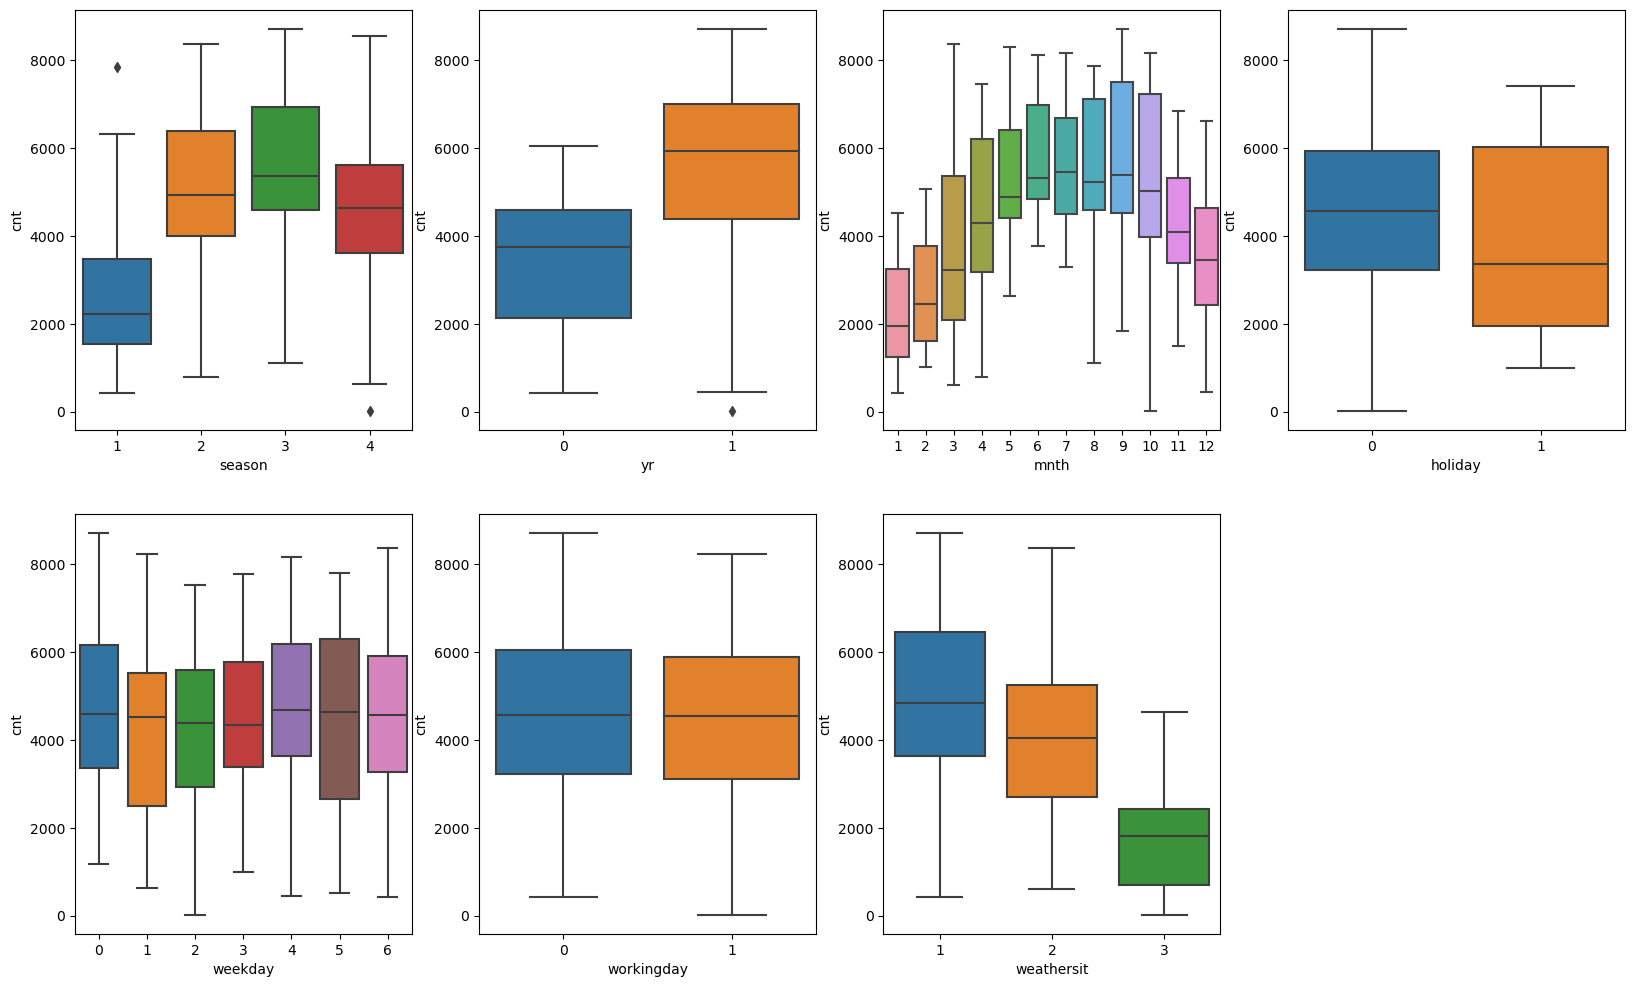

In [9]:
plt.figure(figsize=(20, 12))
plt.subplot(2,4,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike_df)
plt.subplot(2,4,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bike_df)
plt.subplot(2,4,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike_df)
plt.subplot(2,4,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike_df)
plt.subplot(2,4,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike_df)
plt.subplot(2,4,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike_df)
plt.subplot(2,4,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike_df)
plt.show()

# Few observations from above heat map:
1. Median of bike rental count is highest for fall season. Need to check the statistical significance of this.
2. Also maximum bike rental count is for fall season.
3. Median of bike rental count is highest for year 2019. Also maximum bike rental count is for year 2019.
4. Highest bike rental count is for month 9 i.e. September.
5. Median of bike rental count is highest for month 7 i.e. July.
6. Lowest bike rental count is for month 10 i.e. October.
7. Median and highest bike rental count is for no holiday days marked with 0.
8. Bike rental median for all days are almost close to each other.
9. Bike rental median for working/non-working days are almost close to each other.
10. Bike rental median is highest for weathersit 1. Also maximum bike rental count is for weathersit 1 and lowest is for weathersit 3.

# Custom Map Functions

In [10]:
# Defining the season map function
def mapping_season_col(x):
    return x.map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})

# Defining the weather map function
def mapping_weathersit_col(x):
    return x.map({1:"weathersit_1", 2:"weathersit_2", 3:"weathersit_3", 4:"weathersit_4"})

# Defining the month map function
def mapping_month_col(x):
    return x.map({1:"month_1", 
                  2:"month_2", 
                  3:"month_3", 
                  4:"month_4",
                  5:"month_5",
                  6:"month_6",
                  7:"month_7",
                  8:"month_8",
                  9:"month_9",
                  10:"month_10",
                  11:"month_11",
                  12:"month_12"})

# Defining the weekday map function
def mapping_weekday_col(x):
    return x.map({0:"Monday", 
                  1:"Tuesday", 
                  2:"Wednesday", 
                  3:"Thursday",
                  4:"Friday",
                  5:"Saturday",
                  6:"Sunday"})

# Applying the function to the season column
bike_df[["season"]] = bike_df[["season"]].apply(mapping_season_col)

# Applying the function to the weathersit column
bike_df[["weathersit"]] = bike_df[["weathersit"]].apply(mapping_weathersit_col)

# Applying the function to the month column
bike_df[["mnth"]] = bike_df[["mnth"]].apply(mapping_month_col)

# Applying the function to the weekday column
bike_df[["weekday"]] = bike_df[["weekday"]].apply(mapping_weekday_col)

# Dummy Variables Encoding

In [11]:
# Get the dummy variables for the feature 'season' and store it in a new variable - 'season_dummy_var'
season_dummy_var = pd.get_dummies(bike_df["season"], drop_first = True)

In [12]:
season_dummy_var.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [13]:
# Get the dummy variables for the feature 'weathersit' and store it in a new variable - 'weathersit_dummy_var'
weathersit_dummy_var = pd.get_dummies(bike_df["weathersit"],drop_first = True)

In [14]:
weathersit_dummy_var.head()

,weathersit_2,weathersit_3
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0


In [15]:
# Get the dummy variables for the feature 'mnth' and store it in a new variable - 'mnth_dummy_var'
mnth_dummy_var = pd.get_dummies(bike_df["mnth"],drop_first = True)

In [16]:
mnth_dummy_var.head()

,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Get the dummy variables for the feature 'weekday' and store it in a new variable - 'weekday_dummy_var'
weekday_dummy_var = pd.get_dummies(bike_df["weekday"],drop_first = True)

In [18]:
weekday_dummy_var.head()

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,0,1,0
1,0,0,0,0,0,1
2,0,0,0,1,0,0
3,0,0,0,0,0,0
4,0,1,0,0,0,0


In [19]:
# Add the results to the original bike_df dataframe

bike_df = pd.concat([bike_df, season_dummy_var, weathersit_dummy_var, mnth_dummy_var, weekday_dummy_var], axis = 1)

In [20]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,spring,0,month_1,0,Tuesday,1,weathersit_2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,spring,0,month_1,0,Wednesday,1,weathersit_2,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,spring,0,month_1,0,Thursday,1,weathersit_1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,spring,0,month_1,0,Friday,1,weathersit_1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,spring,0,month_1,0,Saturday,1,weathersit_1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [21]:
drop_these_columns_2 = ["season",
                        "weathersit",
                        "mnth",
                        "weekday",
                        "casual",
                        "registered"]
bike_df.drop(drop_these_columns_2, inplace=True, axis=1)
bike_df.shape

(730, 30)

In [22]:
bike_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,1,14.110847,18.18125,80.5833,10.749882,985,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,14.902598,17.68695,69.6087,16.652113,801,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [23]:
bike_df.shape

(730, 30)

# Splitting the Data into Training and Testing Sets
As we know, the first basic step for regression is performing a train-test split.

In [24]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
bike_df_train, bike_df_test = train_test_split(bike_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [25]:
bike_df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
653,1,0,1,19.201653,23.0423,55.8333,12.208807,7534,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
576,1,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
426,1,0,0,16.980847,20.6746,62.1250,10.792293,4066,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
728,1,0,1,10.489153,11.5850,48.3333,23.500518,1796,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
482,1,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [26]:
# Apply scaler() to all the columns except the '0-1' and 'dummy' variables
scaler = MinMaxScaler()

num_vars = ["temp", "atemp", "hum", "windspeed", "cnt"]

bike_df_train[num_vars] = scaler.fit_transform(bike_df_train[num_vars])


In [27]:
bike_df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
728,1,0,1,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [28]:
bike_df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.711765,0.537262,0.512989,0.650369,0.320768,0.513620,0.243137,0.245098,0.24902,0.343137,0.029412,0.086275,0.086275,0.084314,0.066667,0.098039,0.078431,0.084314,0.074510,0.076471,0.096078,0.080392,0.137255,0.147059,0.129412,0.135294,0.154902,0.152941
std,0.500429,0.157763,0.453386,0.225844,0.212385,0.145882,0.169797,0.224593,0.429398,0.430568,0.43287,0.475223,0.169124,0.281045,0.281045,0.278131,0.249689,0.297660,0.269113,0.278131,0.262857,0.266010,0.294988,0.272166,0.344454,0.354512,0.335985,0.342373,0.362166,0.360284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# As we can see from above table, all values have been mapped between 0 and 1 where maximum value is 1 and minimum value is 0. This has been performed by MinMaxScaler().

# Dividing into X and Y sets for the model building

In [29]:
y_train = bike_df_train.pop('cnt')
X_train = bike_df_train ## assigning all feature variables to X_train

# Building our model
This time, we will be using the LinearRegression function from SciKit Learn for its compatibility with RFE (which is a utility from sklearn)

# RFE (Recursive Feature Elimination)

In [30]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10) # running RFE with 10 selected features
rfe = rfe.fit(X_train, y_train)


In [31]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 10),
 ('temp', True, 1),
 ('atemp', False, 9),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', False, 4),
 ('summer', True, 1),
 ('winter', True, 1),
 ('weathersit_2', False, 2),
 ('weathersit_3', True, 1),
 ('month_10', False, 3),
 ('month_11', False, 17),
 ('month_12', False, 18),
 ('month_2', False, 15),
 ('month_3', False, 5),
 ('month_4', False, 7),
 ('month_5', False, 6),
 ('month_6', False, 8),
 ('month_7', False, 16),
 ('month_8', True, 1),
 ('month_9', True, 1),
 ('Monday', False, 12),
 ('Saturday', False, 20),
 ('Sunday', False, 11),
 ('Thursday', False, 19),
 ('Tuesday', False, 14),
 ('Wednesday', False, 13)]

In [32]:
col = X_train.columns[rfe.support_] ## variables suggested by RFE
col

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'summer', 'winter',
       'weathersit_3', 'month_8', 'month_9'],
      dtype='object')

In [33]:
X_train.columns[~rfe.support_] ## rejected variables

Index(['workingday', 'atemp', 'spring', 'weathersit_2', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

# Building model using statsmodel, for the detailed statistics
We are assuming significance level of 0.05.

In [34]:
# Calculate the VIFs for the new model
def calculate_VIF(col,X_train):
    vif = pd.DataFrame()
    vif['Features'] = col
    vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif)

In [35]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [36]:
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

In [37]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the 1st linear model

In [38]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     248.7
Date:                Mon, 15 May 2023   Prob (F-statistic):          1.16e-186
Time:                        10:57:20   Log-Likelihood:                 494.69
No. Observations:                 510   AIC:                            -967.4
Df Residuals:                     499   BIC:                            -920.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2762      0.026     10.565   

# Looking at the p-values, it looks like holiday variable is not really significant (in the presence of other variables).

Maybe we could drop it?

We could simply drop the variable with the highest, non-significant p value. A better way would be to supplement this with the VIF information.

Checking VIF
Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating VIF is:



In [39]:
calculate_VIF(col,X_train)

,Features,VIF
3,hum,10.01
2,temp,8.51
4,windspeed,3.57
0,yr,2.01
5,summer,1.81
6,winter,1.74
8,month_8,1.57
9,month_9,1.30
7,weathersit_3,1.09
1,holiday,1.04


# We need to bring all VIFs below 5 to avoid multicollinearity issue.

# Model 2

In [40]:
X_train_new = X_train[col].drop(["holiday"], axis = 1) # dropping holiday variable

In [41]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [42]:
lm_2 = sm.OLS(y_train,X_train_lm).fit()   # Running the 2nd linear model

In [43]:
#Let's see the summary of our linear model
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     269.2
Date:                Mon, 15 May 2023   Prob (F-statistic):          2.18e-185
Time:                        10:57:20   Log-Likelihood:                 488.79
No. Observations:                 510   AIC:                            -957.6
Df Residuals:                     500   BIC:                            -915.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2712      0.026     10.280   

In [44]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
2,hum,9.99
1,temp,8.51
3,windspeed,3.56
0,yr,2.01
4,summer,1.81
5,winter,1.74
7,month_8,1.57
8,month_9,1.30
6,weathersit_3,1.09


# Model 3

In [45]:
X_train_new = X_train_new.drop(["hum"], axis = 1) # dropping "hum" variable

In [46]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [47]:
lm_3 = sm.OLS(y_train,X_train_lm).fit()   # Running the 3rd linear model

In [48]:
#Let's see the summary of our linear model
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     253.3
Date:                Mon, 15 May 2023   Prob (F-statistic):          1.22e-170
Time:                        10:57:20   Log-Likelihood:                 451.18
No. Observations:                 510   AIC:                            -884.4
Df Residuals:                     501   BIC:                            -846.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0861      0.018      4.921   

In [49]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
1,temp,4.99
2,windspeed,2.99
0,yr,2.00
3,summer,1.78
6,month_8,1.57
4,winter,1.45
7,month_9,1.29
5,weathersit_3,1.06


# Model 4

In [52]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [53]:
lm_4 = sm.OLS(y_train,X_train_lm).fit()   # Running the 4th linear model

In [54]:
#Let's see the summary of our linear model
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     253.3
Date:                Mon, 15 May 2023   Prob (F-statistic):          1.22e-170
Time:                        10:58:27   Log-Likelihood:                 451.18
No. Observations:                 510   AIC:                            -884.4
Df Residuals:                     501   BIC:                            -846.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0861      0.018      4.921   

In [55]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
1,temp,4.99
2,windspeed,2.99
0,yr,2.00
3,summer,1.78
6,month_8,1.57
4,winter,1.45
7,month_9,1.29
5,weathersit_3,1.06


# Model 5

In [56]:
X_train_new = X_train_new.drop(["month_8"], axis = 1) ## dropping month_8

In [57]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [58]:
lm_5 = sm.OLS(y_train,X_train_lm).fit()   # Running the 5th linear model

In [59]:
#Let's see the summary of our linear model
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     286.4
Date:                Mon, 15 May 2023   Prob (F-statistic):          8.49e-171
Time:                        10:58:41   Log-Likelihood:                 448.62
No. Observations:                 510   AIC:                            -881.2
Df Residuals:                     502   BIC:                            -847.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0835      0.018      4.761   

In [60]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
1,temp,3.63
2,windspeed,2.95
0,yr,2.00
3,summer,1.54
4,winter,1.34
6,month_9,1.19
5,weathersit_3,1.06


# Model 6

In [62]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [63]:
lm_6 = sm.OLS(y_train,X_train_lm).fit()   # Running the 6th linear model

In [64]:
#Let's see the summary of our linear model
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     286.4
Date:                Mon, 15 May 2023   Prob (F-statistic):          8.49e-171
Time:                        10:58:57   Log-Likelihood:                 448.62
No. Observations:                 510   AIC:                            -881.2
Df Residuals:                     502   BIC:                            -847.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0835      0.018      4.761   

In [65]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
1,temp,3.63
2,windspeed,2.95
0,yr,2.00
3,summer,1.54
4,winter,1.34
6,month_9,1.19
5,weathersit_3,1.06


# Model 7

In [66]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [67]:
lm_7 = sm.OLS(y_train,X_train_lm).fit()   # Running the 7th linear model

In [68]:
#Let's see the summary of our linear model
print(lm_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     286.4
Date:                Mon, 15 May 2023   Prob (F-statistic):          8.49e-171
Time:                        10:59:43   Log-Likelihood:                 448.62
No. Observations:                 510   AIC:                            -881.2
Df Residuals:                     502   BIC:                            -847.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0835      0.018      4.761   

In [69]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
1,temp,3.63
2,windspeed,2.95
0,yr,2.00
3,summer,1.54
4,winter,1.34
6,month_9,1.19
5,weathersit_3,1.06


# 1. Model 7 is our final model.
2. R-Squared value 0.800 and adjusted R-Squared value is 0.797.
3. All VIFs are now below 5.
4. All p-values are below 0.05 (Rejecting the NULL hypothesis)

# Residual Analysis of the train data
So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [70]:
y_train_cnt = lm_7.predict(X_train_lm)

In [71]:
## Looking at the RMSE

#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_train, y_train_cnt))

0.10040070296154575

In [72]:
%matplotlib inline

Text(0.5, 0, 'Errors')

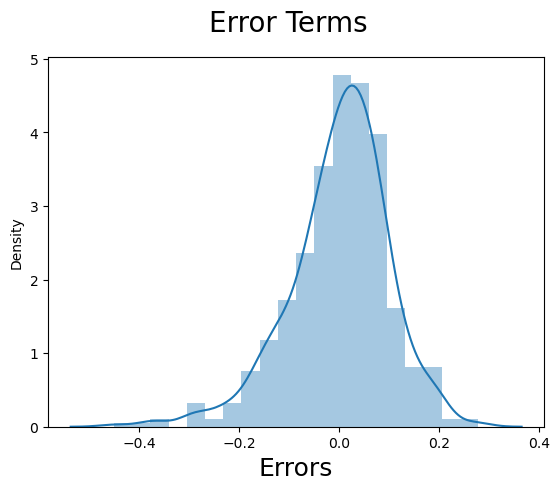

In [73]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

# The residuals are following the normally distributed with a mean 0. All good!

# Looking for patterns in the residuals

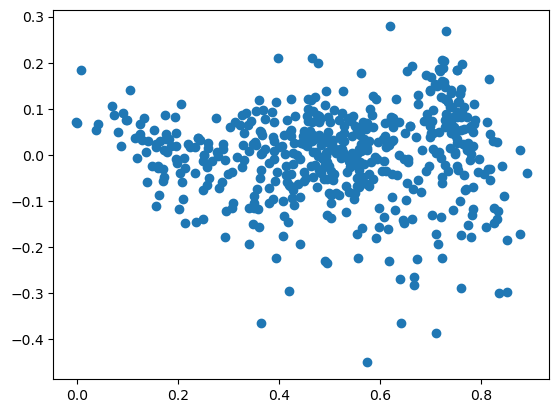

In [74]:
plt.scatter(y_train_cnt,(y_train - y_train_cnt))
plt.show()


# From above plot we can see that residuals (also known as error terms) are independent. This means that there is no correlation between the residuals and the predicted values, or among the residuals themselves.

We are confident that the model fit isn't by chance, and has decent predictive power. The normality of residual terms allows some inference on the coefficients.

# Making Predictions
Applying the scaling on the test sets

In [75]:
# Apply scaler() to all the columns except the '0-1' and 'dummy' variables
num_vars = ["temp", "atemp", "hum", "windspeed", "cnt"]

bike_df_test[num_vars] = scaler.transform(bike_df_test[num_vars])

In [76]:
bike_df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
299,0,0,0,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
152,0,0,0,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


# Dividing into X_test and y_test

In [77]:
y_test = bike_df_test.pop('cnt')
X_test = bike_df_test

In [78]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [79]:
# Making predictions
y_pred = lm_7.predict(X_test_new)

# Model Evaluation

Text(0, 0.5, 'y_pred')

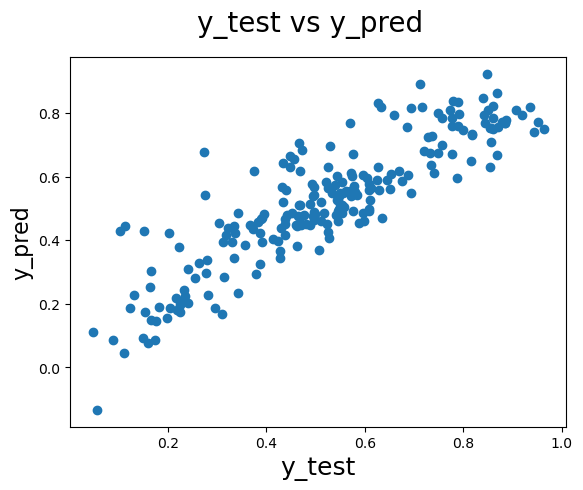

In [80]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

# Looking at the RMSE

In [81]:
#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_test, y_pred))

0.10493973149226847

In [82]:
R2 = r2_score(y_test, y_pred)
R2

0.7681406491531884

In [83]:
adj_R2 = 1-(1-R2)*(219-1)/(219-12-1)
adj_R2

0.7546342792009468

# So final r2_score (R-Squared) for test set is 0.7681

# And Adjusted R-Squared value for test set is 0.754

In [84]:
print(lm_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     286.4
Date:                Mon, 15 May 2023   Prob (F-statistic):          8.49e-171
Time:                        11:01:39   Log-Likelihood:                 448.62
No. Observations:                 510   AIC:                            -881.2
Df Residuals:                     502   BIC:                            -847.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0835      0.018      4.761   

In [87]:
summary_df = pd.DataFrame({"Model Performance Metrics":["R-Squared Value","Adjusted R-Squared Value","RMSE"],
                         "Train Set":[0.800,0.797,0.1004],
                         "Test Set":[0.7681,0.754,0.1049]})

# Conclusion

In [88]:
summary_df

,Model Performance Metrics,Train Set,Test Set
0,R-Squared Value,0.8000,0.7681
1,Adjusted R-Squared Value,0.7970,0.7540
2,RMSE,0.1004,0.1049


Statistically significant and important predictor variables are as follows:
1) yr
2) workingday
3) temp
4) windspeed
5) spring
6) winter
7) weathersit_2
8) weathersit_3
9) month_3
10) month_4
11) month_5
12) month_9
So the company should keep in mind the aforementioned predictor variables while preparing bike rental strategy.